In [55]:
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
from glob import glob

from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import jaccard_score

import sys
sys.path.append('../')
from torchlib.metrics import get_metrics

import staple

In [56]:
def show(src, titles=[], suptitle="", 
         bwidth=4, bheight=4, save_file=False,
         show_axis=True, show_cbar=False):

    num_cols = len(src)
    
    plt.figure(figsize=(bwidth * num_cols, bheight))
    plt.suptitle(suptitle)

    for idx in range(num_cols):
        plt.subplot(1, num_cols, idx+1)
        if not show_axis: plt.axis("off")
        if idx < len(titles): plt.title(titles[idx])
        plt.imshow(src[idx]*1)
        if type(show_cbar) is bool:
            if show_cbar: plt.colorbar()
        elif idx < len(show_cbar) and show_cbar[idx]:
            plt.colorbar()
        
    plt.tight_layout()
    if save_file:
        plt.savefig(save_file)
        
def show2(src, titles=[], suptitle="", 
         bwidth=4, bheight=4, save_file=False,
         show_axis=True, show_cbar=False):

    num_cols = len(src)
    
    plt.figure(figsize=(bwidth * num_cols//2, bheight*2))
    plt.suptitle(suptitle)

    for idx in range(num_cols):
        plt.subplot(2, num_cols//2, idx+1)
        if not show_axis: plt.axis("off")
        if idx < len(titles): plt.title(titles[idx])
        plt.imshow(src[idx]*1)
        if type(show_cbar) is bool:
            if show_cbar: plt.colorbar()
        elif idx < len(show_cbar) and show_cbar[idx]:
            plt.colorbar()
        
    plt.tight_layout()
    if save_file:
        plt.savefig(save_file)

# Data

In [57]:
def dice_score(gt, seg):
    jac = jaccard_score(gt.ravel(), seg.ravel())
    dice = (2*jac)/ (1+jac)
    return dice

def to3(src):
    shape = src.shape
    return np.stack((np.zeros_like(src), 1-src, src), axis=2)

def get_title(src, gt, prefix=""):
    results, n_cells, preds = get_metrics(to3(gt), to3(src), post_label='map')
    predictionlb, prediction, region, output = preds
    title = f"Np: {results['n_cells']} PQ: {results['pq']:0.2f}"
    return prefix + title

In [58]:
img_id = "0023"
segs = ([cv2.imread(url, -1)//255 for url in sorted(glob(f"/home/chcp/Datasets/Seg1009_0.4.1/test/outputs/*/{img_id}.tif"))])
n_segs = len(segs)
gt = cv2.imread(f"/home/chcp/Datasets/Seg1009_0.4.1/test/labels2c/{img_id}.tif", -1)
gt = cv2.dilate(gt, np.ones((3,3)))
mv = np.array(segs).sum(0) >= (n_segs//2)

In [59]:
_, n_cells, preds = get_metrics(to3(gt), to3(gt), post_label='map')

In [60]:
title_segs = [get_title(src, gt, f"Seg{idx} ") for idx, src in enumerate(segs)]
title_mv   = get_title(mv, gt, "MV ")

Text(0.5, 1.0, 'D Matrix')

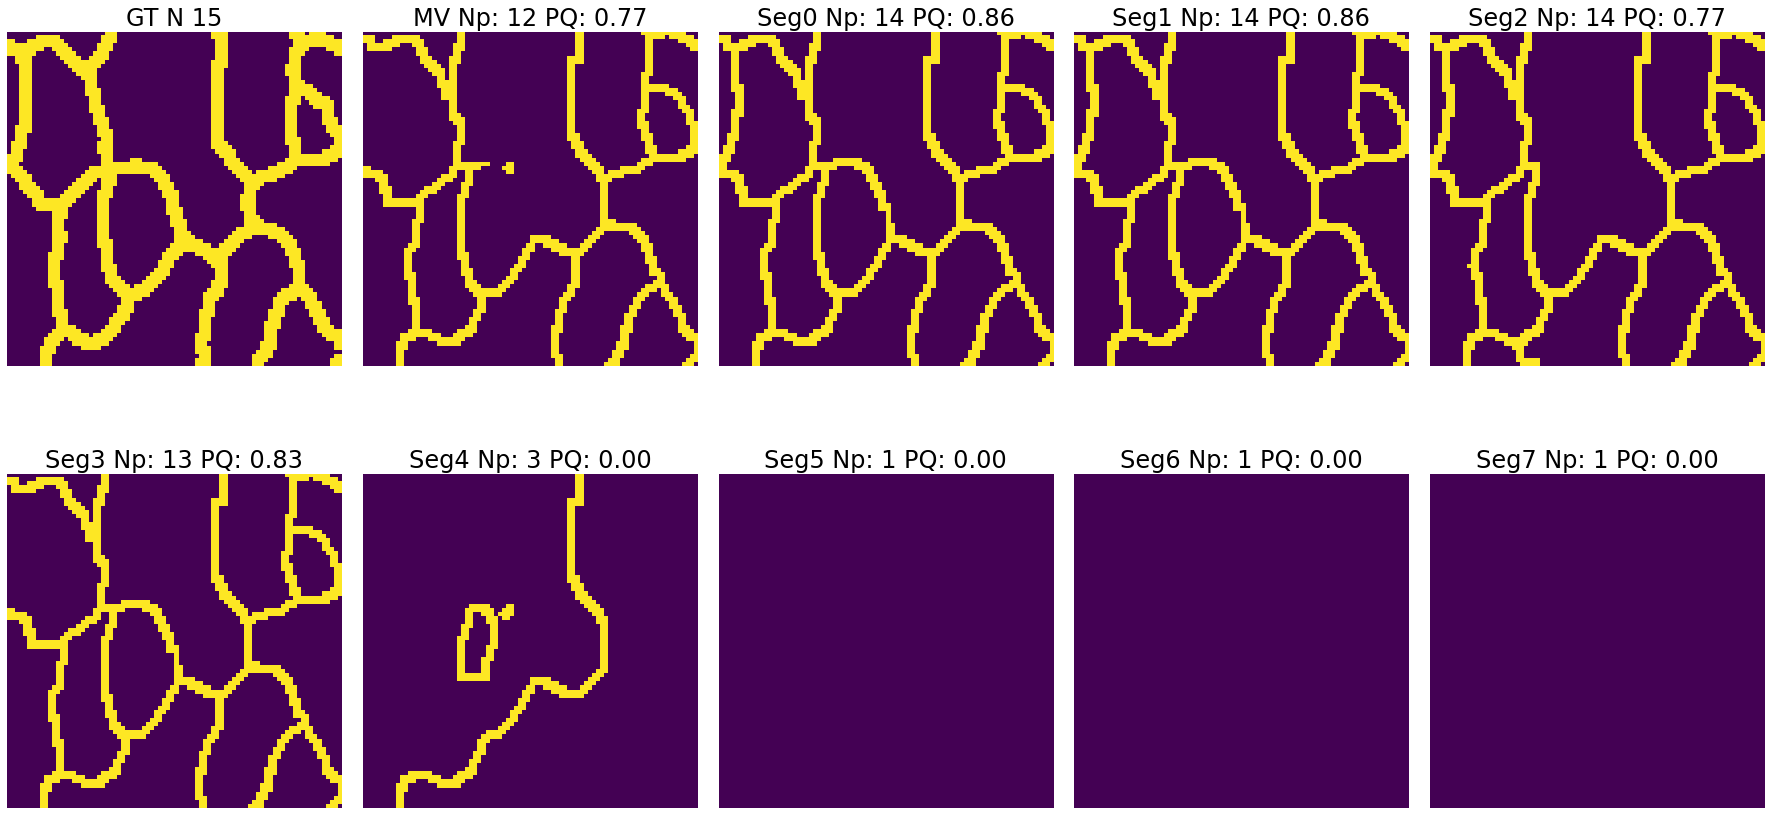

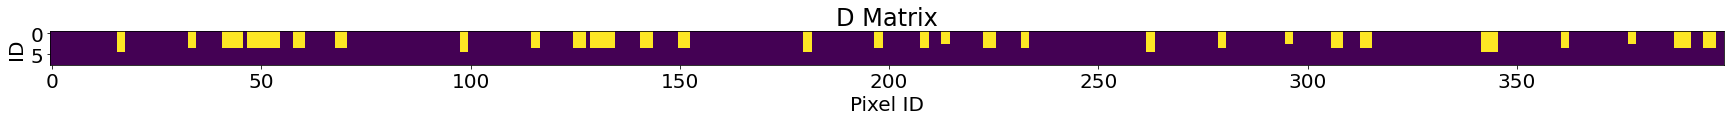

In [61]:
plt.rcParams.update({'font.size': 20})

show_list = [gt, mv] + segs
show_titles= [f"GT N {n_cells}", title_mv] + title_segs
show2(show_list, titles=show_titles, bheight=7, bwidth=5, show_axis=False)

plt.figure(figsize=(30, 20))
plt.imshow(np.array(segs).reshape(n_segs, -1)[:, 200:600])#.shape
plt.xlabel("Pixel ID")
plt.ylabel("ID")
plt.title("D Matrix")

# STAPLE

In [35]:
staple_res = staple.STAPLE(list(segs)).run()
staple_res = staple_res > 0.5
title_staple = get_title(staple_res, gt)

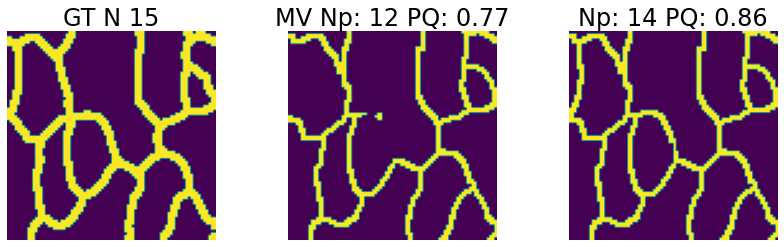

In [36]:
plt.rcParams.update({'font.size': 20})

show([gt, mv, staple_res], 
     titles= [f"GT N {n_cells}", title_mv, title_staple],
     show_axis=False)

# Non Weight Simple

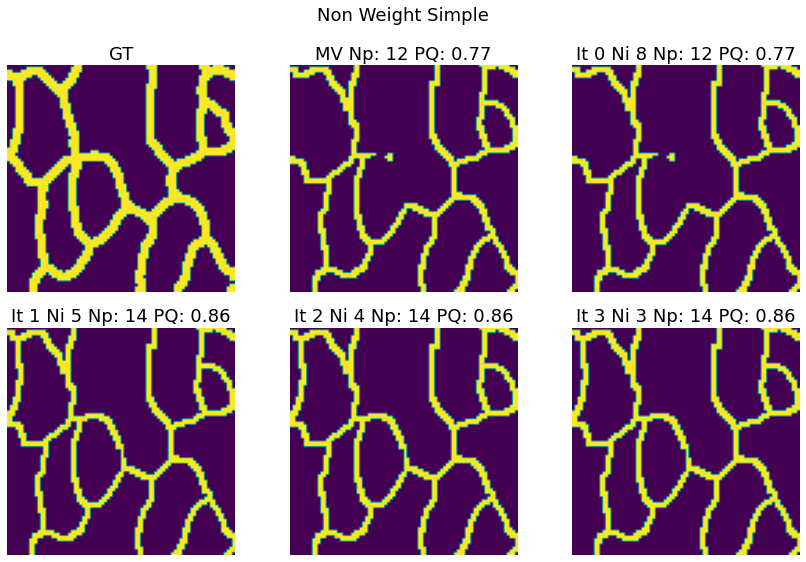

In [39]:
new_segs = np.array(segs).copy()
results, n_segs = [], []
alfa   = 1
mdices = []
titles = []

for epoch in range(4):
    MV = (new_segs.sum(0)>= new_segs.shape[0]//2)
    titles.append(get_title(MV, gt, f"It {epoch} Ni {new_segs.shape[0]} "))
    results.append(MV)
    n_segs.append(len(new_segs))
    seg_score = []
    for seg in new_segs:
        jac = jaccard_score(MV.ravel(), seg.ravel())
        dice = (2*jac)/ (1+jac)
        seg_score.append([dice, seg])


    seg_score  = np.array(seg_score, dtype=object)
    #sorted_seg = np.array(sorted(seg_score, key=lambda x:x[0], reverse=True))
    wdice = seg_score[:, 0].sum()
    mdice = seg_score[:, 0].mean()
    sdice = seg_score[:, 0].std()
    
    t = mdice - (alfa*sdice)
    new_segs = np.array((list(filter(lambda x: x[0]> t, seg_score))))
    new_segs = new_segs[:, 1]

plt.rcParams.update({'font.size': 15})    
show2([gt, mv] + results, suptitle="Non Weight Simple",
      show_axis=False,titles=['GT', title_mv] + titles)

In [254]:
sscores = [dice_score(gt, pred) for pred in results]

titles = [f"GT: {scores[0]:0.2f}", f"MV: {scores[1]:0.2f}"] + [f"Iter {idx}: {s:0.2f}" for idx, s in enumerate(sscores)]

show2([gt, mv] + results, show_axis=False,
      titles=titles)

ValueError: Unknown format code 'f' for object of type 'str'

# SIMPLE

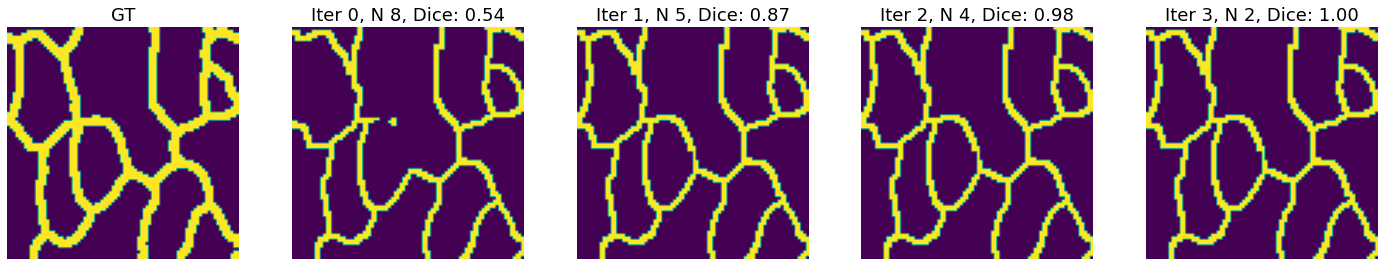

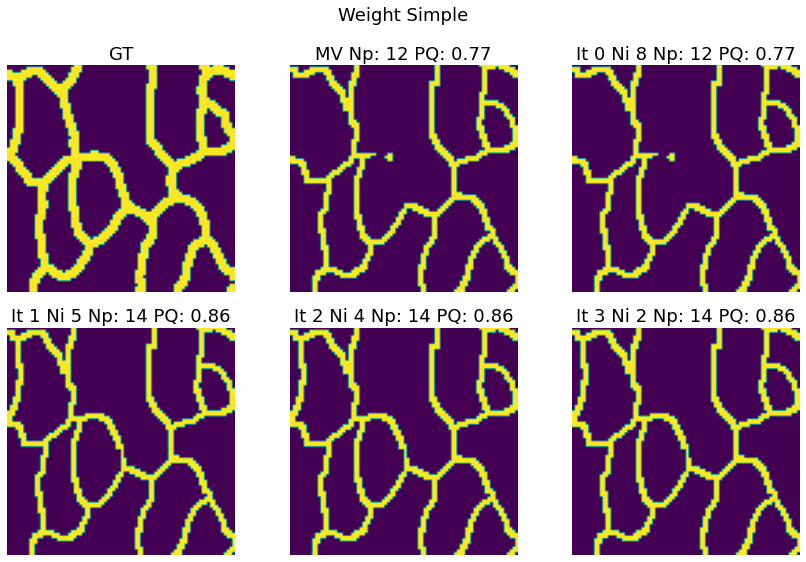

In [43]:
new_segs = np.array(segs).copy()
results, n_segs = [], []
alfa = 0.2
MV = (new_segs.sum(0)>= new_segs.shape[0]//2)
new_weights = np.ones(len(new_segs))
mdices = []
titles = []


for epoch in range(6):
    
    MV = (new_segs.transpose(1,2,0) * new_weights).sum(2) >= (new_weights.sum()/2)
    titles.append(get_title(MV, gt, f"It {epoch} Ni {new_segs.shape[0]} "))
    results.append(MV)
    n_segs.append(len(new_segs))
    
    dices = []
    for seg in new_segs:
        jac = jaccard_score(MV.ravel(), seg.ravel())
        dice = (2*jac)/ (1+jac)
        dices.append(dice)

    dices  = np.array(dices)
    #sorted_seg = np.array(sorted(seg_score, key=lambda x:x[0], reverse=True))
    wdice = dices.sum()
    mdice = dices.mean()
    sdice = dices.std()
    mdices.append(mdice)
    
    t = mdice - (alfa * sdice)
    new_segs = new_segs[dices > t]
    new_weights = dices[dices > t]
    if len(new_segs)<=1:
        break
    
show([gt] + results, show_axis=False,
     titles=['GT'] + [f"Iter {idx}, N {n}, Dice: {mdice:0.2f}" for idx, (n, mdice) in enumerate(zip(n_segs, mdices))])

plt.rcParams.update({'font.size': 15})    
show2([gt, mv] + results, suptitle="Weight Simple",
      show_axis=False,titles=['GT', title_mv] + titles)

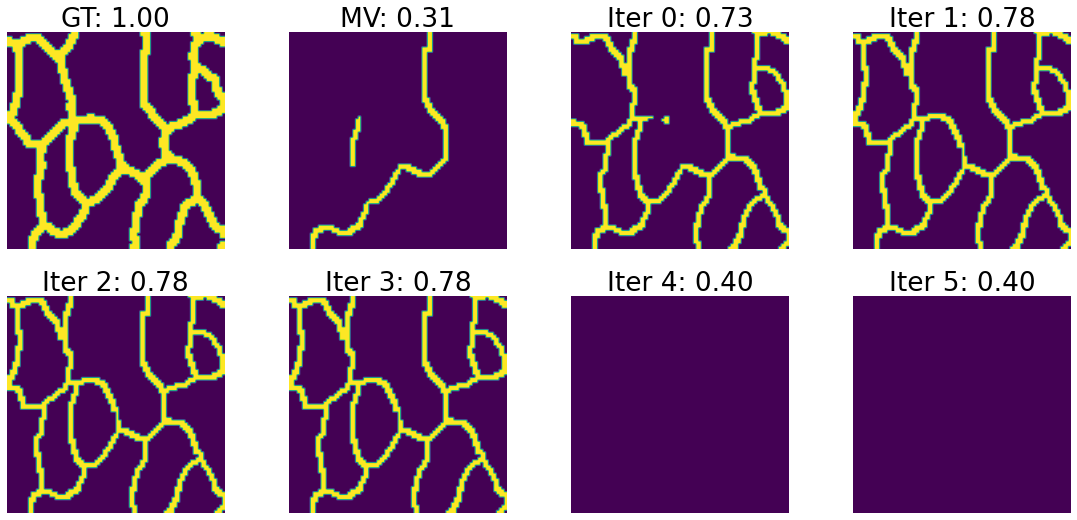

In [46]:
sscores = [dice_score(gt, pred) for pred in results]

titles = [f"GT: {scores[0]:0.2f}", f"MV: {scores[1]:0.2f}"] + [f"Iter {idx}: {s:0.2f}" for idx, s in enumerate(sscores)]

show2([gt, mv] + results, show_axis=False,
      titles=titles)